# SETUP

In [15]:
%%capture
!pip install xarray
!pip install wandb
!pip install collections
!pip install pysteps
!pip install beartype
!pip install scikit-image
!pip install netcdf4

In [1]:
import os
new_directory = '/dss/dsshome1/0D/ge74xuf2/climate_diffusion'
os.chdir(new_directory)
os.getcwd()

'/dss/dsshome1/0D/ge74xuf2/climate_diffusion'

In [2]:
import os
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr
import wandb
import IPython.display as display
import logging
import torch.nn.functional as F
import collections
import copy
import torchvision.transforms as transforms


from PIL import Image
from tqdm import tqdm
from torch import optim
from PIL import Image
from torch.utils import data
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
from inspect import isfunction
from functools import partial
from abc import abstractmethod
from skimage.metrics import structural_similarity as ssim
from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.ticker as ticker

import tqdm
#from src.psd_utils import SpatialSpectralDensity_4_diff_res, SpatialSpectralDensity_diff_res

from src.utils import *
from src.utils_essential import *

from src.base_network import BaseNetwork

from src.imagen_unet_and_diffusion import *
from src.imagen_unet import UNet
from src.imagen_unet import *

from src.dataloader_sr import gfdl_eval_256, era5_upscaled_1d_256, era5_0_25d_256, qm_gfdl_trafo_units_hr
from src.dataloader_sr import QM_GFDL_LR_Dataset_256
from src.dataloader_sr import SR_BC_GFDL_Dataset_256

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## GFDL eval


In [10]:
bs_eval = 1400

In [11]:
era5_hr_ds = era5_0_25d_256(stage='valid')
era5_hr_dl = data.DataLoader(era5_hr_ds, batch_size=bs_eval, shuffle=False, drop_last=True)
era5_hr_val = next(iter(era5_hr_dl))
print("HR ERA5", era5_hr_val.shape)

HR ERA5 torch.Size([1400, 1, 256, 256])


In [12]:
sr_gfdl_val_sr_dataset_n0 = SR_BC_GFDL_Dataset_256('data/revision_100_no_nosie_e100_19_09.pth') 
dataloader_sr_gfdl_val_n0 = data.DataLoader(sr_gfdl_val_sr_dataset_n0, batch_size=1400,shuffle=False, drop_last=True)

dm_hr_gfdl_n0 = next(iter(dataloader_sr_gfdl_val_n0))
print("DM corrected noise=10 :",dm_hr_gfdl_n0.shape)

/dss/dsshome1/0D/ge74xuf2/climate_diffusion/src/dataloader_sr.py:491: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.hr_bc_gfdl = torch.load(self.path)


dataset size torch.Size([1400, 1, 256, 256])
DM corrected noise=10 : torch.Size([1400, 1, 256, 256])


In [13]:
sr_gfdl_val_sr_dataset_n50 = SR_BC_GFDL_Dataset_256('data/100_gfdl_sr_imagen_e100_6_09.pth') 
dataloader_sr_gfdl_val_n50 = data.DataLoader(sr_gfdl_val_sr_dataset_n50, batch_size=1400,shuffle=False, drop_last=True)

dm_hr_gfdl_n50 = next(iter(dataloader_sr_gfdl_val_n50))
print("DM corrected noise=50:",dm_hr_gfdl_n50.shape)

dataset size torch.Size([1400, 1, 256, 256])
DM corrected noise=50: torch.Size([1400, 1, 256, 256])


In [14]:
sr_gfdl_val_sr_dataset_n80 = SR_BC_GFDL_Dataset_256('data/revision_gfdl_sr_noise_80_i100_e100_18_09.pth') 
dataloader_sr_gfdl_val_n80 = data.DataLoader(sr_gfdl_val_sr_dataset_n80, batch_size=1400,shuffle=False, drop_last=True)

dm_hr_gfdl_n80 = next(iter(dataloader_sr_gfdl_val_n80))
print("DM corrected noise=80:",dm_hr_gfdl_n80.shape)

dataset size torch.Size([1400, 1, 256, 256])
DM corrected noise=80: torch.Size([1400, 1, 256, 256])


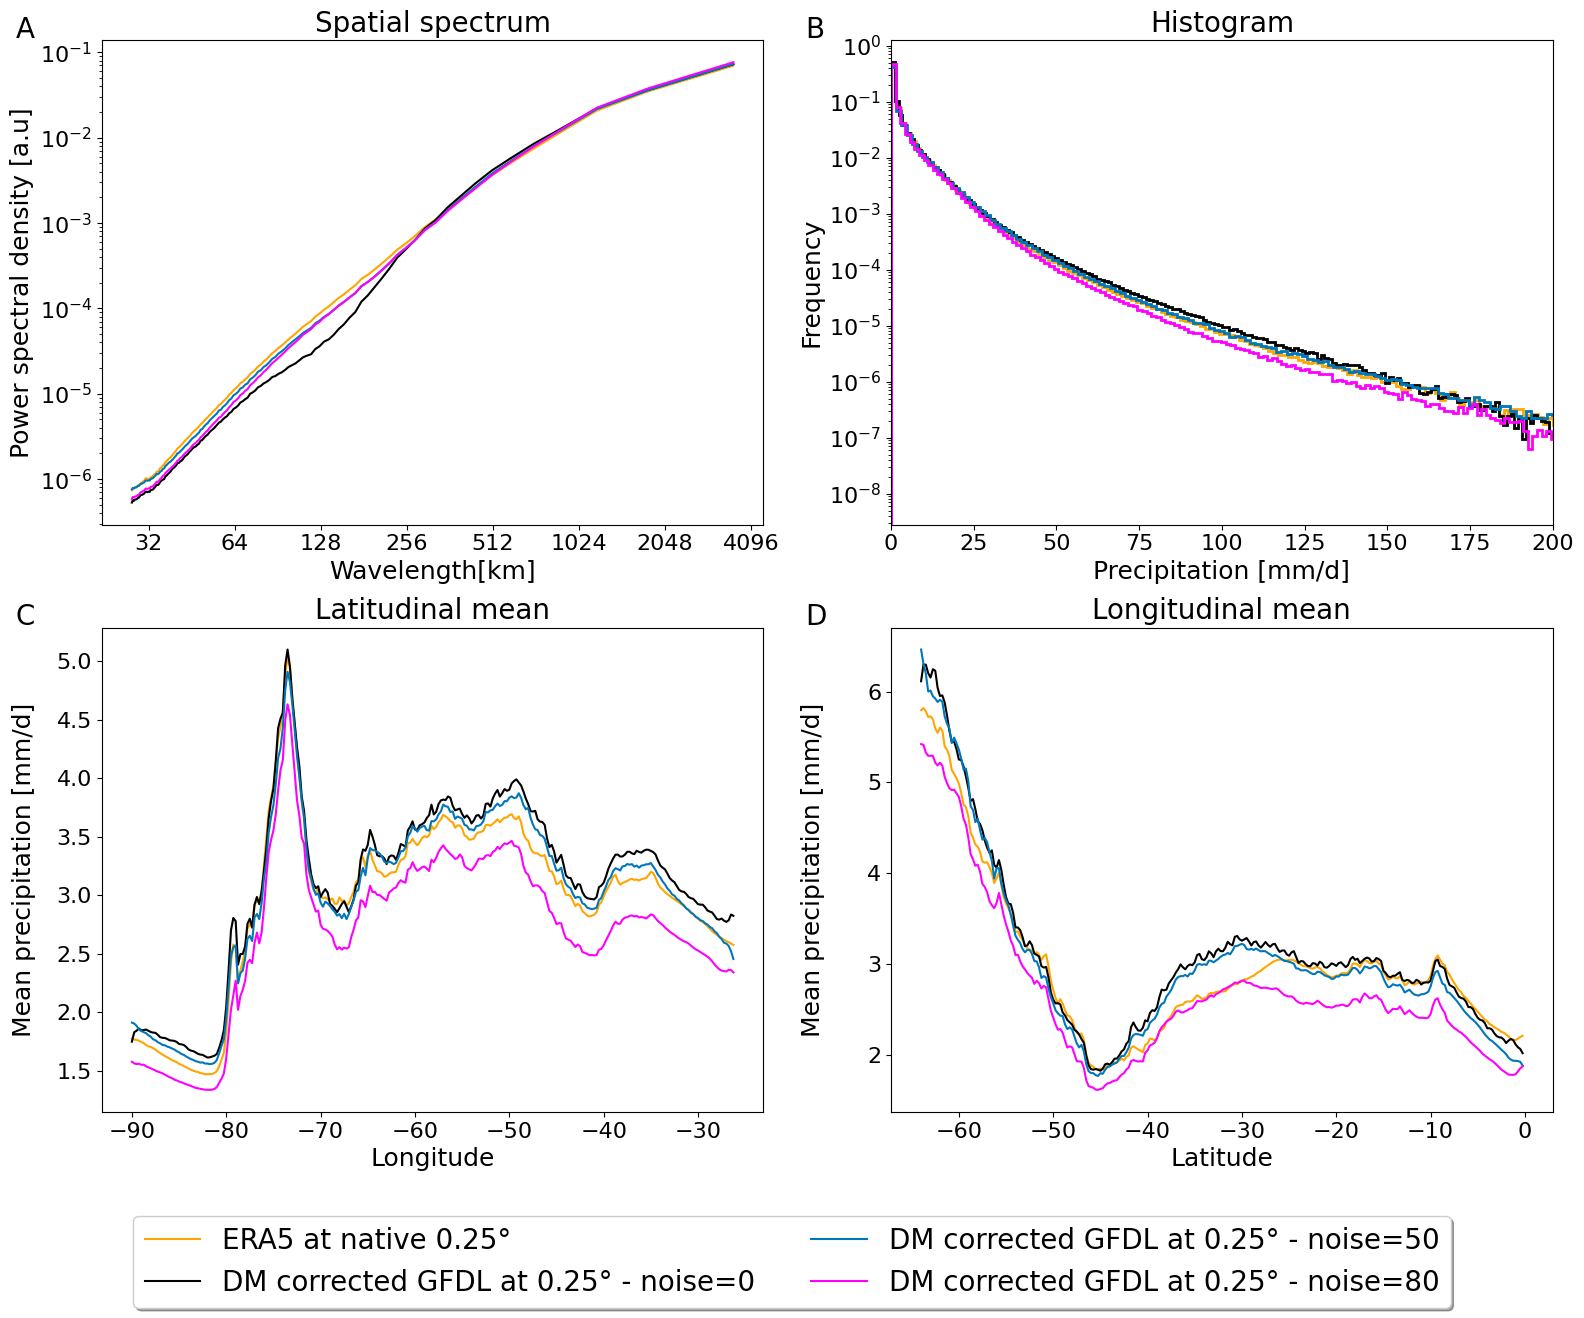

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))

ssd = SpatialSpectralDensity_4_diff_res( era5_hr_ds.inverse_dwd_trafo(era5_hr_val).numpy()
                                      ,era5_hr_ds.inverse_dwd_trafo(dm_hr_gfdl_n0.cpu().numpy())
                                      ,era5_hr_ds.inverse_dwd_trafo(dm_hr_gfdl_n50.cpu().numpy())
                                      ,era5_hr_ds.inverse_dwd_trafo(dm_hr_gfdl_n80.cpu().numpy())
                                      ,new_labels=['ERA5 at native 0.25°',
                                                   'DM corrected GFDL at 0.25° - noise=0',
                                                   "DM corrected GFDL at 0.25° - noise=50",
                                                   'DM corrected GFDL at 0.25° - noise=80']
                                      ,y_ax_name='Power spectral density [a.u]',x_ax_name=r'Wavelength[km]',
                                       title="Spatial spectrum" )
ssd.run(num_times=None)

ssd.plot_psd(model_resolution=0.25, model_resolution_2=0.25, do_savefig=False, axis=axs[0, 0])
axs[0, 0].text(-0.13, 1.05, 'A', transform=axs[0, 0].transAxes, fontsize=20, fontweight='light', va='top')
axs[0, 0].set_title("Spatial spectrum", fontsize=20)  

histograms_four_np(  era5_hr_ds.inverse_dwd_trafo(era5_hr_val).numpy()
                  ,era5_hr_ds.inverse_dwd_trafo(dm_hr_gfdl_n0.cpu().numpy())
                  ,era5_hr_ds.inverse_dwd_trafo(dm_hr_gfdl_n50.cpu().numpy())
                  ,era5_hr_ds.inverse_dwd_trafo(dm_hr_gfdl_n80.cpu().numpy())
                  ,label_name=['ERA5 at native 0.25°',
                               'DM corrected GFDL at 0.25° - noise=0',
                               "DM corrected GFDL at 0.25° - noise=50",
                               'DM corrected GFDL at 0.25° - noise=80']
                     ,xlim_end=200, bins=300, y_ax_name="Frequency", x_ax_name="Precipitation [mm/d]"
                     ,title_name="Histogram"
                     ,do_savefig=False, ax=axs[0, 1])
axs[0, 1].text(-0.13, 1.05, 'B', transform=axs[0, 1].transAxes, fontsize=20, fontweight='light', va='top')
axs[0, 1].set_title("Histogram", fontsize=20)  # Increase title size

latitudinal_mean_four_np( era5_hr_ds.inverse_dwd_trafo(era5_hr_val).numpy()
                      ,era5_hr_ds.inverse_dwd_trafo(dm_hr_gfdl_n0.cpu().numpy())
                      ,era5_hr_ds.inverse_dwd_trafo(dm_hr_gfdl_n50.cpu().numpy())
                      ,era5_hr_ds.inverse_dwd_trafo(dm_hr_gfdl_n80.cpu().numpy())
                      ,label_name=['ERA5 at native 0.25°',
                                   'DM corrected GFDL at 0.25° - noise=0',
                                   "DM corrected GFDL at 0.25° - noise=50",
                                   'DM corrected GFDL at 0.25° - noise=80']
                          ,y_ax_name="Mean precipitation [mm/d]", x_ax_name="Longitude"
                         ,title_name="Latitudinal mean"
                         ,do_savefig=False, ax=axs[1, 0])
axs[1, 0].text(-0.13, 1.05, 'C', transform=axs[1, 0].transAxes, fontsize=20, fontweight='light', va='top')
axs[1, 0].set_title("Latitudinal mean", fontsize=20)

longitudinal_mean_four_np( era5_hr_ds.inverse_dwd_trafo(era5_hr_val).numpy()
                          ,era5_hr_ds.inverse_dwd_trafo(dm_hr_gfdl_n0.cpu().numpy())
                          ,era5_hr_ds.inverse_dwd_trafo(dm_hr_gfdl_n50.cpu().numpy())
                          ,era5_hr_ds.inverse_dwd_trafo(dm_hr_gfdl_n80.cpu().numpy())
                          ,label_name=['ERA5 at native 0.25°',
                                       'DM corrected GFDL at 0.25° - noise=0',
                                       "DM corrected GFDL at 0.25° - noise=50",
                                       'DM corrected GFDL at 0.25° - noise=80']
                          ,y_ax_name="Mean precipitation [mm/d]", x_ax_name="Latitude"
                         ,title_name="Longitudinal mean"
                         ,do_savefig=False, ax=axs[1, 1])
axs[1, 1].text(-0.13, 1.05, 'D', transform=axs[1, 1].transAxes, fontsize=20, fontweight='light', va='top')
axs[1, 1].set_title("Longitudinal mean", fontsize=20)

# Set label padding only for subplots C and D (second row)
#for ax in axs[1, :]:  
axs[1,0].yaxis.labelpad = 15  
axs[1,1].yaxis.labelpad = 30 

#axs[1, 1].yaxis.set_major_locator(ticker.MultipleLocator(0.5))

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0)
           ,fancybox=True, shadow=True, ncol=2, fontsize=20)

plt.tight_layout(rect=[0, 0.06, 1, 0.95])
plt.subplots_adjust(bottom=0.15)

plt.savefig('figures_paper/psd_comp_noise_lvls.pdf', dpi=300)
plt.show()